In [171]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
import seaborn as sns
from keras.models import load_model
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
import shap
from scipy.stats import pearsonr
import sys
sys.path.insert(0, '/Users/huripari/Documents/PhD/TCs_Genesis/FS_TCG')
import utils_results as ut

In [172]:
basin = 'NA'
perc = 80 
cluster_data_info = {'GLB': 'nc12', 'NEP': 'DSnc12', 'NWP': 'Anc10', 'NA': 'DSnc6', 'NI': 'DSnc12', 'SI':'DSnc9', 'SP': 'nc7'}
basin_names = {'GLB': 'Global', 'NEP': 'North East Pacific',  'NWP': 'North West Pacific', 'NA': 'North Atlantic',
              'NI': 'North Indian', 'SI': 'South Indian', 'SP': 'South Pacific'}
cluster_data = cluster_data_info[basin]
basin_name = basin_names[basin]
run_name = f'selfeat{perc}_top20_{cluster_data}_nv8_nd9'
years = np.arange(1980, 2022, 1) # from 1980 to 2021 included
n_folds = 3
n_clusters = int(run_name.split('nc')[1].split('_')[0])
nc_string = run_name.split('_')[2]
project_dir = '/Users/huripari/Documents/PhD/TCs_Genesis'
fs_dir = os.path.join(project_dir, 'FS_TCG')
# Load the file containing the time series of the predictors and of the target
if 'DS' in nc_string:
    clusters_data = f'{basin}_{n_clusters}clusters_deseason'
elif 'A' in nc_string:
    clusters_data = f'{basin}_{n_clusters}clusters_anomaly'
else:
    clusters_data = f'{basin}_{n_clusters}clusters'
cluster_data_dir = os.path.join(fs_dir, 'data', f'{clusters_data}')
predictor_file = f'predictors_1970-2022_{n_clusters}clusters_8vars_9idxs.csv'
predictors_df = pd.read_csv(os.path.join(cluster_data_dir, predictor_file), index_col=0)
predictors_df.index = pd.to_datetime(predictors_df.index)

In [173]:
# Get the run info and data
run_info = ut.runs_info(basin, run_name)
dataset_opt = run_info[0]
dataset_opt_noFS = run_info[1]
Y_pred = run_info[2]
Y_pred_noFS = run_info[3]
Y_test = run_info[4]
X_test_eval = run_info[5]
X_test_eval_noFS = run_info[6]
mlps = run_info[7]
mlps_noFS = run_info[8]
perm_importance_mlp = run_info[9]
perm_importance_mlp_noFS = run_info[10]
shap_values_mlp = run_info[11]
shap_values_mlp_noFS = run_info[12]
X_test = pd.concat(X_test_eval)
X_test_noFS = pd.concat(X_test_eval_noFS)

In [174]:
# Load the seasonality if working with deseason data
if "DS" in nc_string:
    cluster_data = f'{basin}_{n_clusters}clusters_deseason'
    data_dir = os.path.join(fs_dir, 'data', cluster_data)
    target_season = 'target_seasonality_1970-2022_2.5x2.5.csv'
    target_season_df = pd.read_csv(os.path.join(data_dir, target_season), index_col=0)
    target_season_df.index = pd.to_datetime(target_season_df.index)

**Time series Trajectories** 

In [175]:
# Concat the predictions and the test values
Y_pred_df = pd.concat(Y_pred)
Y_test_df = pd.concat(Y_test)
Y_pred_noFS_df = pd.concat(Y_pred_noFS)
# Create df containing the deseasonalized time series
Y_pred_df_noS = Y_pred_df.copy()
Y_test_df_noS = Y_test_df.copy()
Y_pred_noFS_df_noS = Y_pred_noFS_df.copy()
# Deseasonalize the time series
if "DS" in nc_string:
    Y_pred_df['tcg'] = Y_pred_df['tcg'] + target_season_df.loc[Y_pred_df.index, 'seasonal']
    Y_test_df = Y_test_df + target_season_df.loc[Y_test_df.index, 'seasonal']
    Y_pred_noFS_df['tcg'] = Y_pred_noFS_df['tcg'] + target_season_df.loc[Y_pred_noFS_df.index, 'seasonal']
    decomp_pred = seasonal_decompose(Y_pred_df, model='additive', period=12)
    decomp_test = seasonal_decompose(Y_test_df, model='additive', period=12)
    decomp_noFS = seasonal_decompose(Y_pred_noFS_df, model='additive', period=12)
else:
    decomp_pred = seasonal_decompose(Y_pred_df, model='additive', period=12)
    decomp_test = seasonal_decompose(Y_test_df, model='additive', period=12)
    decomp_noFS = seasonal_decompose(Y_pred_noFS_df, model='additive', period=12)
    Y_pred_df_noS['tcg'] = Y_pred_df['tcg'] - decomp_pred.seasonal
    Y_test_df_noS = Y_test_df - decomp_test.seasonal
    Y_pred_noFS_df_noS['tcg'] = Y_pred_noFS_df['tcg'] - decomp_noFS.seasonal
# Load time series of gpis
gpis_path = os.path.join(fs_dir, 'data', f'{basin}_2.5x2.5_gpis_time_series.csv')
gpis_df = pd.read_csv(gpis_path, index_col=0)
gpis_df.index = pd.to_datetime(gpis_df.index)
gpis_df = gpis_df.loc[Y_pred_df.index]
engpi = gpis_df['engpi']
ogpi = gpis_df['ogpi']
# Deseasonalize the time series of gpis
decomp_engpi = seasonal_decompose(engpi, model='additive')
decomp_ogpi = seasonal_decompose(ogpi, model='additive')
engpi_noS = engpi - decomp_engpi.seasonal
ogpi_noS = ogpi - decomp_ogpi.seasonal
# values smaller than 0 are set to 0
Y_pred_df.loc[Y_pred_df['tcg'] < 0, 'tcg'] = 0.0
Y_pred_noFS_df.loc[Y_pred_noFS_df['tcg'] < 0, 'tcg'] = 0.0
# Compute seasonal mean values
Y_pred_df_season = Y_pred_df.groupby(Y_pred_df.index.month).mean()
Y_test_df_season = Y_test_df.groupby(Y_test_df.index.month).mean()
Y_pred_noFS_df_season = Y_pred_noFS_df.groupby(Y_pred_noFS_df.index.month).mean()
engpi_seasonal = engpi.groupby(engpi.index.month).mean()
ogpi_seasonal = ogpi.groupby(ogpi.index.month).mean()
# Compute annual cumulative values
Y_pred_df_annual = Y_pred_df.groupby(Y_pred_df.index.year).sum()
Y_test_df_annual = Y_test_df.groupby(Y_test_df.index.year).sum()
Y_pred_noFS_df_annual = Y_pred_noFS_df.groupby(Y_pred_noFS_df.index.year).sum()
engpi_annual = engpi.groupby(engpi.index.year).sum()
ogpi_annual = ogpi.groupby(ogpi.index.year).sum()
# Remove trend from annual time series
Y_pred_df_noT = Y_pred_df.copy()
Y_test_df_noT = Y_test_df.copy()
Y_pred_noFS_df_noT = Y_pred_noFS_df.copy()
Y_pred_df_noT['tcg'] = Y_pred_df['tcg'] - decomp_pred.trend
Y_test_df_noT = Y_test_df - decomp_test.trend
Y_pred_noFS_df_noT['tcg'] = Y_pred_noFS_df['tcg'] - decomp_noFS.trend
engpi_noT = engpi - decomp_engpi.trend
ogpi_noT = ogpi - decomp_ogpi.trend
Y_pred_df_annual_noT = Y_pred_df_noT.groupby(Y_pred_df_noT.index.year).sum()
Y_test_df_annual_noT = Y_test_df_noT.groupby(Y_test_df_noT.index.year).sum()
Y_pred_noFS_df_annual_noT = Y_pred_noFS_df_noT.groupby(Y_pred_noFS_df_noT.index.year).sum()
engpi_annual_noT = engpi_noT.groupby(engpi_noT.index.year).sum()
ogpi_annual_noT = ogpi_noT.groupby(ogpi_noT.index.year).sum()
# Compute the correlation coefficient and the MSE between the predictions and the test values
# Monthly
r, _ = pearsonr(Y_test_df_noS, Y_pred_df_noS['tcg']) # correllation compute with the deseasonalized values
r_noFS, _ = pearsonr(Y_test_df_noS, Y_pred_noFS_df_noS['tcg'])
r_engpi, _ = pearsonr(Y_test_df_noS, engpi_noS)
r_ogpi, _ = pearsonr(Y_test_df_noS, ogpi_noS)
mse = mean_squared_error(Y_test_df, Y_pred_df['tcg']) # mean squared error compute with the original values
mse_noFS = mean_squared_error(Y_test_df, Y_pred_noFS_df['tcg'])
mse_engpi = mean_squared_error(Y_test_df, engpi)
mse_ogpi = mean_squared_error(Y_test_df, ogpi)
# Seasonal
rS, _ = pearsonr(Y_test_df_season, Y_pred_df_season['tcg'])
rS_noFS, _ = pearsonr(Y_test_df_season, Y_pred_noFS_df_season['tcg'])
rS_engpi, _ = pearsonr(Y_test_df_season, engpi_seasonal)
rS_ogpi, _ = pearsonr(Y_test_df_season, ogpi_seasonal)
mseS = mean_squared_error(Y_test_df_season, Y_pred_df_season['tcg'])
mseS_noFS = mean_squared_error(Y_test_df_season, Y_pred_noFS_df_season['tcg'])
mseS_engpi = mean_squared_error(Y_test_df_season, engpi_seasonal)
mseS_ogpi = mean_squared_error(Y_test_df_season, ogpi_seasonal)
# Annual
rY, _ = pearsonr(Y_test_df_annual_noT, Y_pred_df_annual_noT['tcg']) # correlation error compute with the detrended values
rY_noFS, _ = pearsonr(Y_test_df_annual_noT, Y_pred_noFS_df_annual_noT['tcg'])
rY_engpi, _ = pearsonr(Y_test_df_annual_noT, engpi_annual_noT)
rY_ogpi, _ = pearsonr(Y_test_df_annual_noT, ogpi_annual_noT)
mseY = mean_squared_error(Y_test_df_annual, Y_pred_df_annual['tcg']) # mean squared error compute with the original values
mseY_noFS = mean_squared_error(Y_test_df_annual, Y_pred_noFS_df_annual['tcg'])
mseY_engpi = mean_squared_error(Y_test_df_annual, engpi_annual)
mseY_ogpi = mean_squared_error(Y_test_df_annual, ogpi_annual)


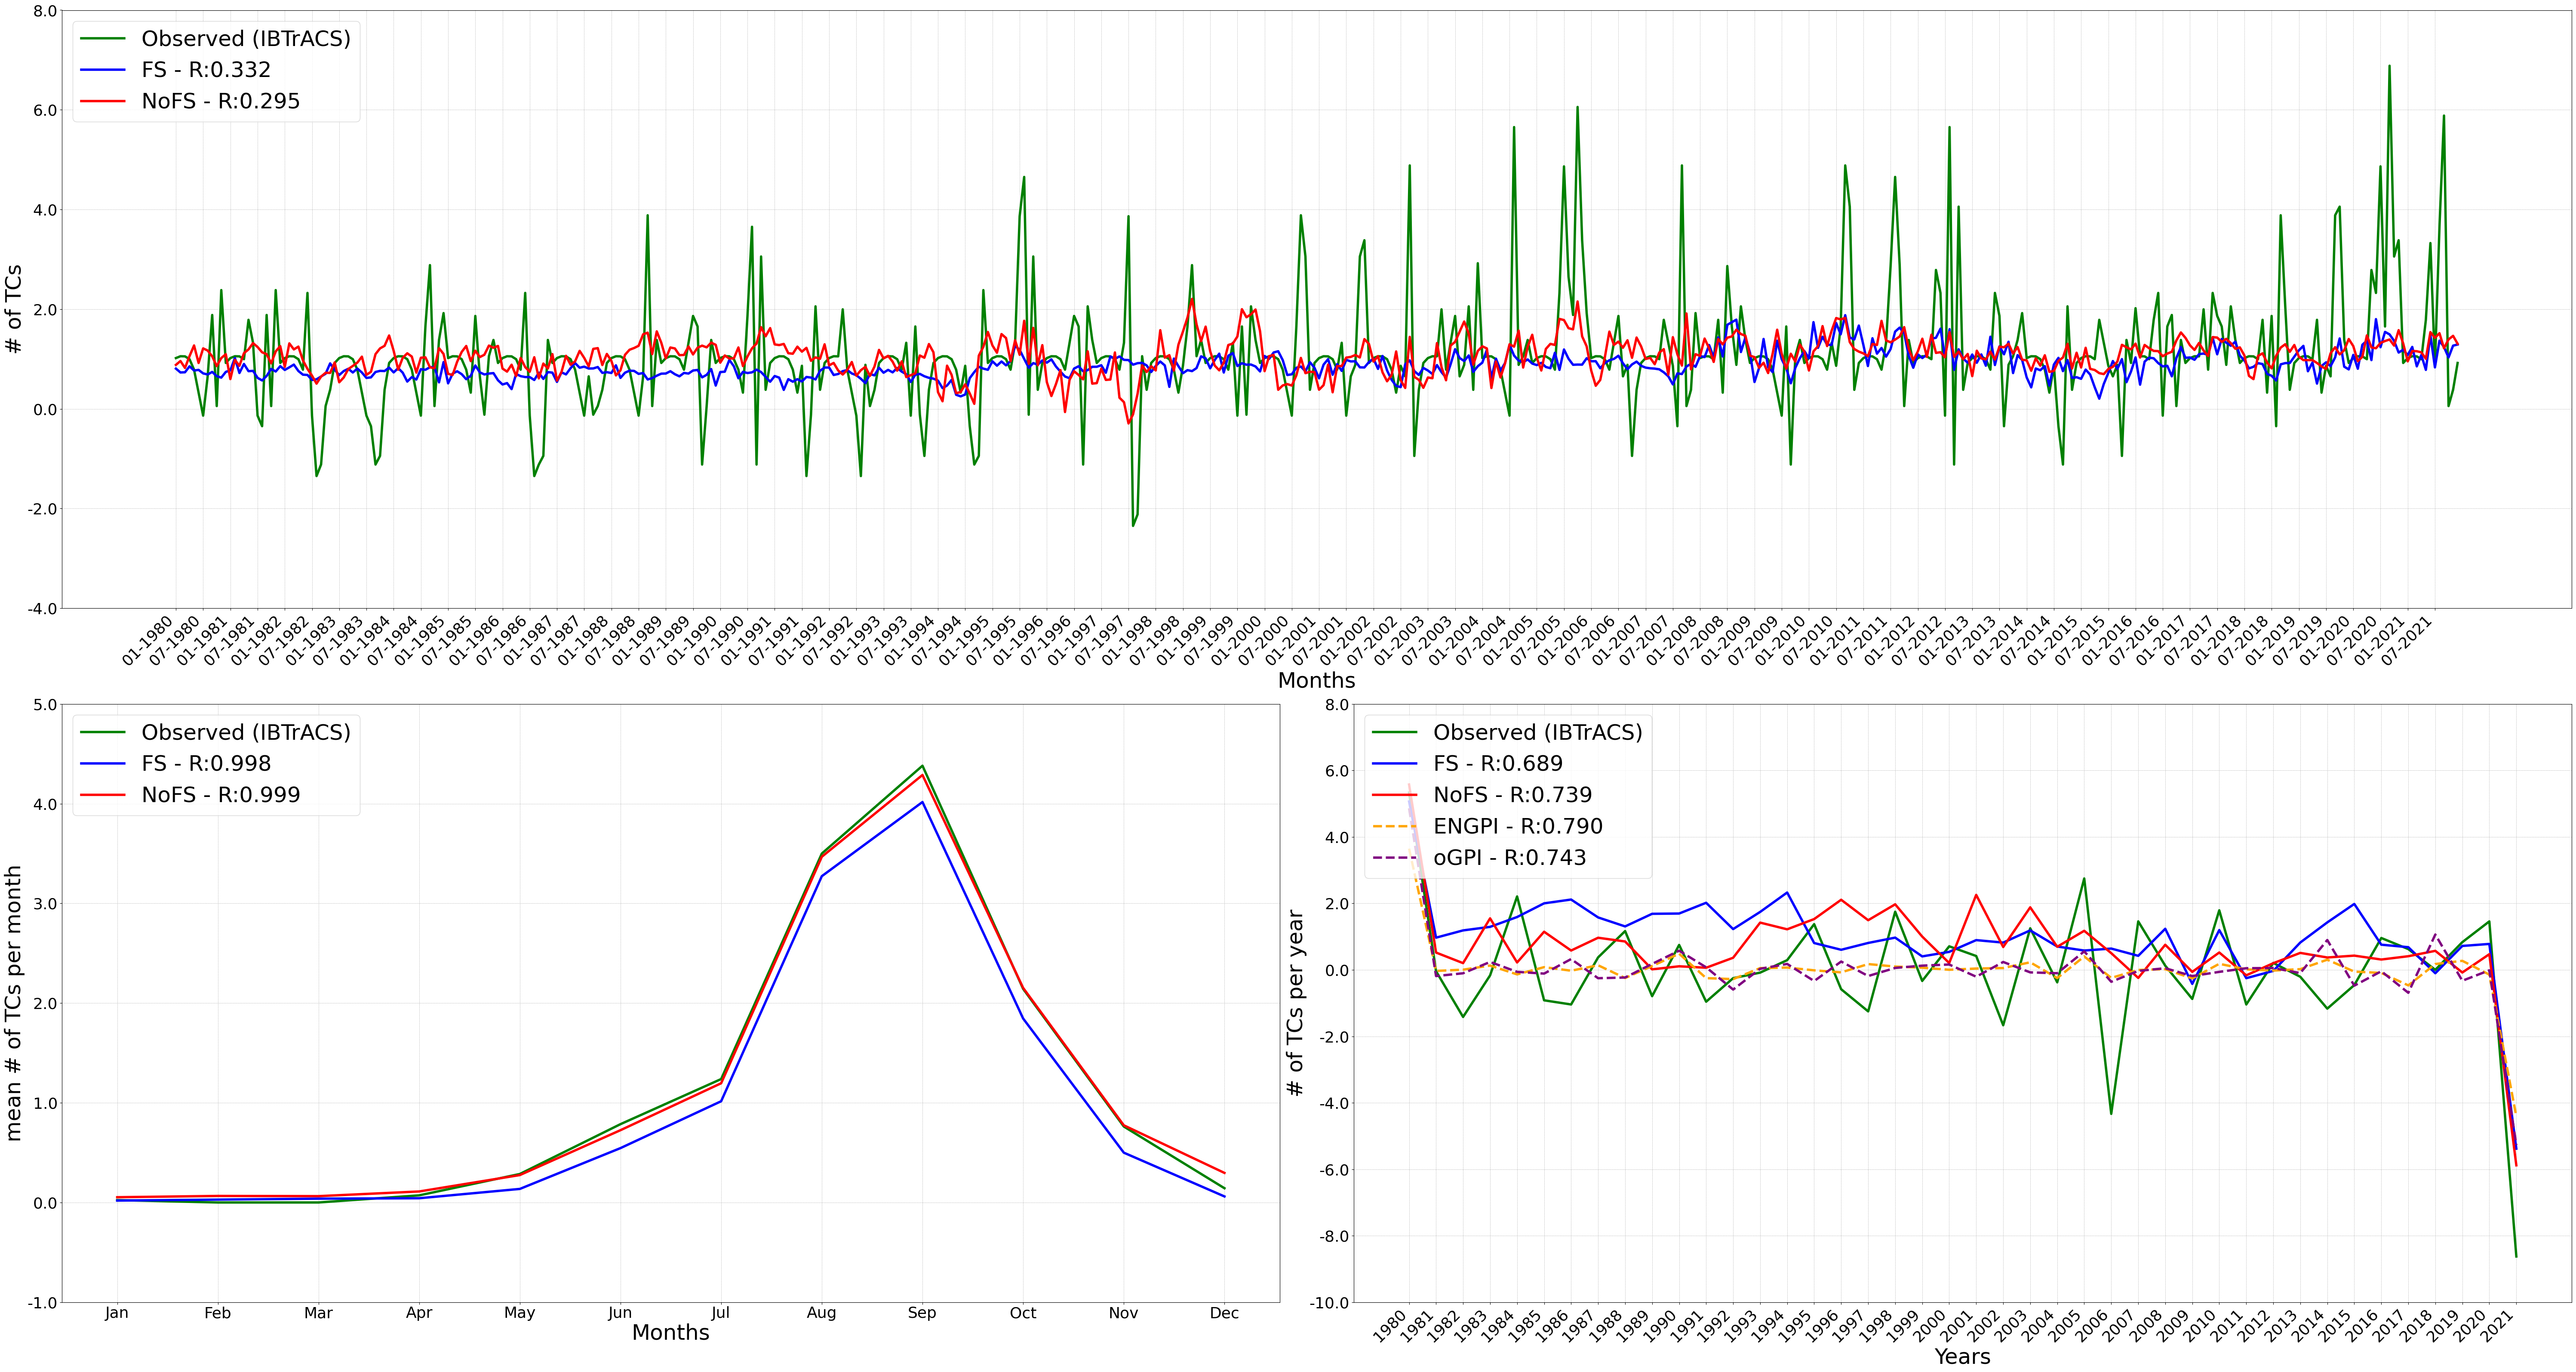

In [176]:
# Plot Time Series 
fig_ts = plt.figure(figsize=(60, 32))
gs = gridspec.GridSpec(2, 2, figure=fig_ts)
## Monthly time series ##
ax = fig_ts.add_subplot(gs[0, :])
xticks = pd.Series(Y_test_df_noS.index).dt.strftime('%m-%Y').to_numpy()
# observations
ax.plot(xticks, Y_test_df_noS, label='Observed (IBTrACS)', color='green', linewidth=4)
# predictions
ax.plot(xticks, Y_pred_df_noS['tcg'], label=f'FS - R:{r:.3f}', color='blue', linewidth=4)
ax.plot(xticks, Y_pred_noFS_df_noS['tcg'], label=f'NoFS - R:{r_noFS:.3f}', color='red', linewidth=4)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.set_xticks(ticks=np.arange(len(xticks))[::6])
ax.set_xticklabels(xticks[::6], rotation=45, fontsize=26, ha='right')
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(ax.get_yticks(), fontsize=26)
ax.set_xlabel('Months', fontsize=36)
ax.set_ylabel('# of TCs', fontsize=36)
ax.legend(fontsize=36, loc='upper left')
## Seasonal time series ##
axS = fig_ts.add_subplot(gs[1, 0])
# observations
axS.plot(Y_test_df_season.index, Y_test_df_season, label='Observed (IBTrACS)', color='green', linewidth=4)
# mlp predictions
axS.plot(Y_pred_df_season.index, Y_pred_df_season['tcg'], label=f'FS - R:{rS:.3f}', color='blue', linewidth=4)
axS.plot(Y_pred_noFS_df_season.index, Y_pred_noFS_df_season['tcg'], label=f'NoFS - R:{rS_noFS:.3f}', color='red', linewidth=4)
axS.grid(True, which='both', linestyle='--', linewidth=0.5)
axS.set_xticks(Y_test_df_season.index)
axS.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=26)
axS.set_yticks(axS.get_yticks())
axS.set_yticklabels(axS.get_yticks(), fontsize=26)
axS.set_xlabel('Months', fontsize=36)
axS.set_ylabel('mean # of TCs per month', fontsize=36)
axS.legend(fontsize=36, loc='upper left')
## Annual time series ##
axY = fig_ts.add_subplot(gs[1, 1])
# observations
axY.plot(Y_test_df_annual_noT.index, Y_test_df_annual_noT, label='Observed (IBTrACS)', color='green', linewidth=4)
# mlp predictions
axY.plot(Y_pred_df_annual_noT.index, Y_pred_df_annual_noT['tcg'], label=f'FS - R:{rY:.3f}', color='blue', linewidth=4)
axY.plot(Y_pred_noFS_df_annual_noT.index, Y_pred_noFS_df_annual_noT['tcg'], label=f'NoFS - R:{rY_noFS:.3f}', color='red', linewidth=4)
# gpis
axY.plot(engpi_annual_noT.index, engpi_annual_noT, label=f'ENGPI - R:{rY_engpi:.3f}', color='orange', linewidth=4, linestyle='--')
axY.plot(ogpi_annual_noT.index, ogpi_annual_noT, label=f'oGPI - R:{rY_ogpi:.3f}', color='purple', linewidth=4, linestyle='--')
axY.grid(True, which='both', linestyle='--', linewidth=0.5)
axY.set_xticks(Y_test_df_annual_noT.index)
axY.set_xticklabels(Y_test_df_annual_noT.index, rotation=45, fontsize=26, ha='right')
axY.set_yticks(axY.get_yticks())
axY.set_yticklabels(axY.get_yticks(), fontsize=26)
axY.set_xlabel('Years', fontsize=36)
axY.set_ylabel('# of TCs per year', fontsize=36)
axY.legend(fontsize=36, loc='upper left')

fig_ts.set_tight_layout(True)
plt.show()

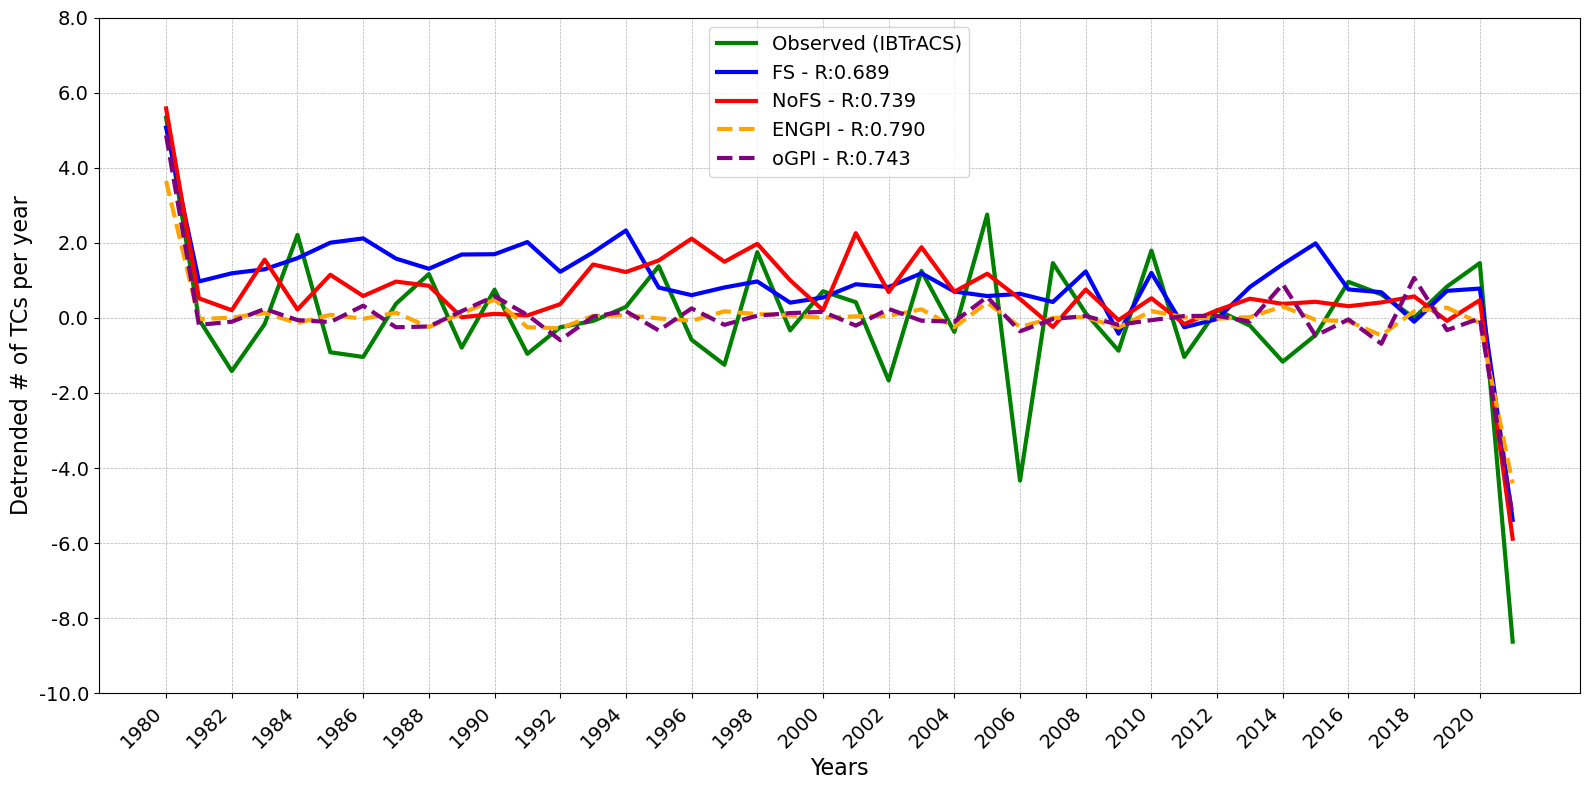

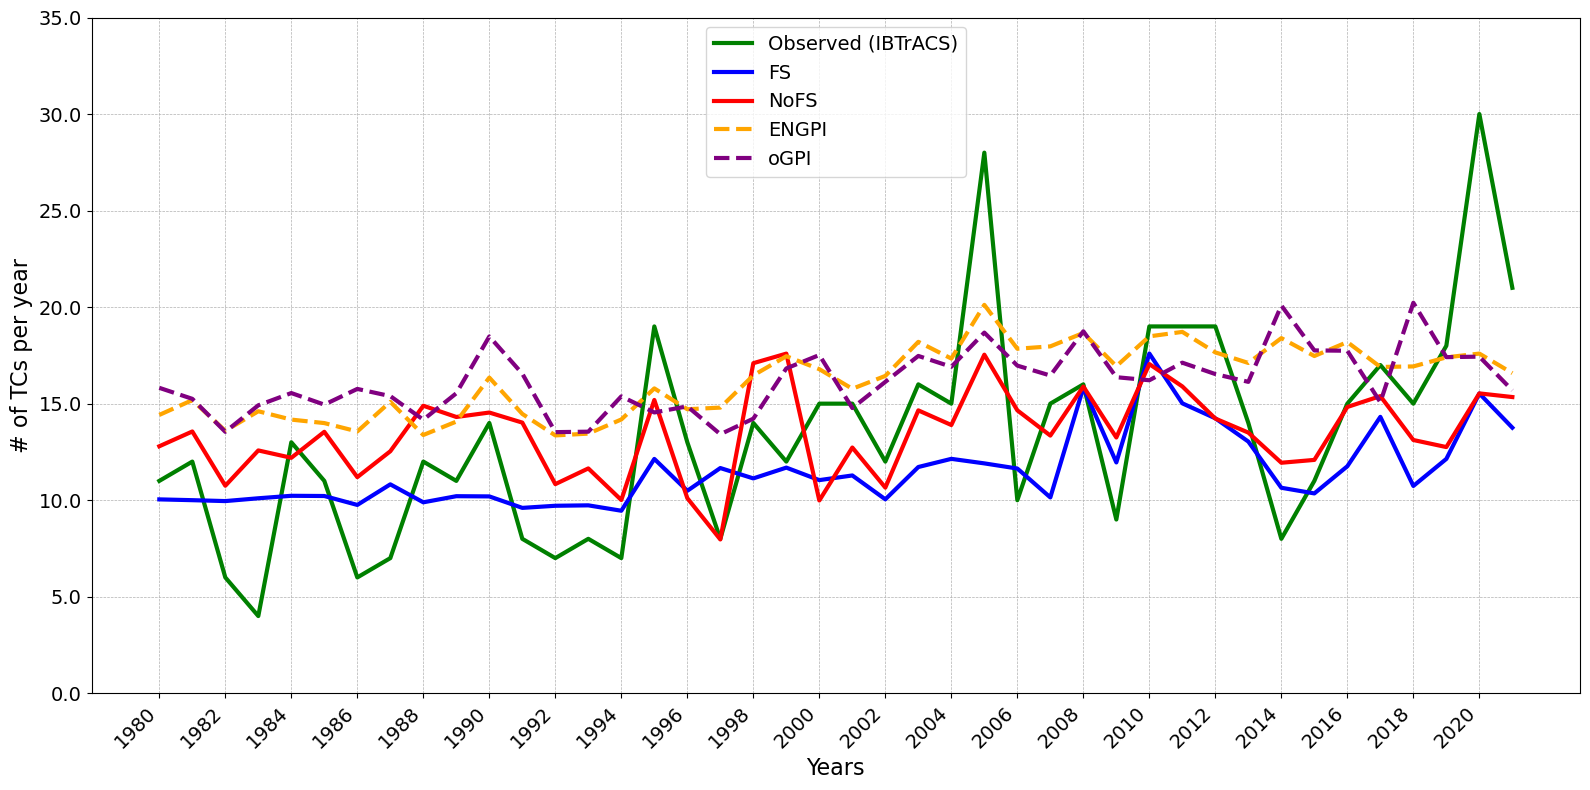

In [177]:
# Plot detrended annual time series
fig_annual = plt.figure(figsize=(16, 8))
axY = fig_annual.add_subplot(111)
# observations
axY.plot(Y_test_df_annual_noT.index, Y_test_df_annual_noT, label='Observed (IBTrACS)', color='green', linewidth=3)
# mlp predictions
axY.plot(Y_pred_df_annual_noT.index, Y_pred_df_annual_noT['tcg'], label=f'FS - R:{rY:.3f}', color='blue', linewidth=3)
axY.plot(Y_pred_noFS_df_annual_noT.index, Y_pred_noFS_df_annual_noT['tcg'], label=f'NoFS - R:{rY_noFS:.3f}', color='red', linewidth=3)
# gpis
axY.plot(engpi_annual_noT.index, engpi_annual_noT, label=f'ENGPI - R:{rY_engpi:.3f}', color='orange', linewidth=3, linestyle='--')
axY.plot(ogpi_annual_noT.index, ogpi_annual_noT, label=f'oGPI - R:{rY_ogpi:.3f}', color='purple', linewidth=3, linestyle='--')
axY.grid(True, which='both', linestyle='--', linewidth=0.5)
axY.set_xticks(Y_test_df_annual_noT.index[::2])
axY.set_xticklabels(Y_test_df_annual_noT.index[::2], rotation=45, fontsize=14, ha='right')
axY.set_yticks(axY.get_yticks())
axY.set_yticklabels(axY.get_yticks(), fontsize=14)
axY.set_xlabel('Years', fontsize=16)
axY.set_ylabel('Detrended # of TCs per year', fontsize=16)
axY.legend(fontsize=14, loc='upper center')
# Save the figure
fig_annual.set_tight_layout(True)
file_name = os.path.join('figures', f'{basin}', f'annual_time_series_noT_{basin}.pdf')
fig_annual.savefig(file_name, format='pdf', bbox_inches='tight', dpi=300)
plt.show()

# Plot annual time series
fig_annual = plt.figure(figsize=(16, 8))
axY = fig_annual.add_subplot(111)
# observations
axY.plot(Y_test_df_annual.index, Y_test_df_annual, label='Observed (IBTrACS)', color='green', linewidth=3)
# mlp predictions
axY.plot(Y_pred_df_annual.index, Y_pred_df_annual['tcg'], label=f'FS', color='blue', linewidth=3)
axY.plot(Y_pred_noFS_df_annual.index, Y_pred_noFS_df_annual['tcg'], label=f'NoFS', color='red', linewidth=3)
# gpis
axY.plot(engpi_annual.index, engpi_annual, label=f'ENGPI', color='orange', linewidth=3, linestyle='--')
axY.plot(ogpi_annual.index, ogpi_annual, label=f'oGPI', color='purple', linewidth=3, linestyle='--')
axY.grid(True, which='both', linestyle='--', linewidth=0.5)
axY.set_xticks(Y_test_df_annual.index[::2])
axY.set_xticklabels(Y_test_df_annual.index[::2], rotation=45, fontsize=14, ha='right')
axY.set_yticks(axY.get_yticks())
axY.set_yticklabels(axY.get_yticks(), fontsize=14)
axY.set_xlabel('Years', fontsize=16)
axY.set_ylabel('# of TCs per year', fontsize=16)
axY.legend(fontsize=14, loc='upper center')
# Save the figure
fig_annual.set_tight_layout(True)
file_name = os.path.join('figures', f'{basin}', f'annual_time_series_{basin}.pdf')
fig_annual.savefig(file_name, format='pdf', bbox_inches='tight', dpi=300)
plt.show()

**Print lines for LaTEX table**

In [178]:
print(f'& FS-NN & {mse:.3f} & {r:.3f} & {mseS:.3f} & {rS:.4f} & {mseY:.3f} & {rY:.3f} \\\\')
print(f'~ & NN & {mse_noFS:.3f} & {r_noFS:.3f} & {mseS_noFS:.3f} & {rS_noFS:.4f} & {mseY_noFS:.3f} & {rY_noFS:.3f} \\\\')
print(f'~ & ENGPI & {mse_engpi:.3f} & {r_engpi:.3f} & {mseS_engpi:.3f} & {rS_engpi:.4f} & {mseY_engpi:.3f} & {rY_engpi:.3f} \\\\')
print(f'~ & oGPI & {mse_ogpi:.3f} & {r_ogpi:.3f} & {mseS_ogpi:.3f} & {rS_ogpi:.4f} & {mseY_ogpi:.3f} & {rY_ogpi:.3f} \\\\')

& FS-NN & 1.156 & 0.332 & 0.040 & 0.9980 & 22.459 & 0.689 \\
~ & NN & 1.124 & 0.295 & 0.004 & 0.9994 & 19.963 & 0.739 \\
~ & ENGPI & 1.425 & 0.379 & 0.323 & 0.9388 & 28.247 & 0.790 \\
~ & oGPI & 1.680 & 0.268 & 0.509 & 0.8919 & 33.405 & 0.743 \\


**SHAP values**

In [186]:
## Set different parameters for following plots ##
# Dictionary containing the couples of years for each fold to used for more deepen analysis
# Fold 1: [1980-1993]
# Fold 2: [1994-2007]
# Fold 3: [2008-2021]
years_couples = {
    # 'basin': ([max_fold1, min_fold1], [max_fold2, min_fold2], [max_fold3, min_fold3])
    'GLB': ([1990, 1987], [1994, 1998], [2015, 2010]),
    'NEP': ([1982, 1988], [1997, 1995], [2015, 2010]),
    'NWP': ([1984, 1993], [2001, 1998], [2012, 2020]),
    'NA': ([1987, 1986], [1995, 2002], [2010, 2015]), # rerun training fold1 and fold2 model do not look very good
    'NI': ([1991, 1984], [1998, 1999], [2018, 2008]),
    'SI': ([1984, 1992], [2000, 1997], [2018, 2015]),
    'SP': ([1983, 1991], [1997, 1999], [2016, 2011])
    }
# Dictionary containing the selected features ordered for consistent shapley values plots
ordered_features = {
    # ordered from lowest impacting to highest impacting in shap values
    'GLB': ['PDO', 'msl_cluster11', 'abs_vo850_cluster6', 'sst_cluster12', 'vws850-200_cluster2', 'vo850_cluster8', 'month', 'abs_vo850_cluster5', 
            'mpi_cluster12', 'sst_cluster9'],
    'NEP': ['WP', 'abs_vo850_cluster9', 'w_cluster3', 'vo850_cluster6', 'vo850_cluster4', 'abs_vo850_cluster6', 'vo850_cluster7', 'r700_cluster5',
            'w_cluster9', 'vo850_cluster1'],
    'NWP': ['TSA', 'PDO', 'r700_cluster4', 'mpi_cluster2', 'msl_cluster4'],
    'NA': ['vo850_cluster6', 'vws850-200_cluster6', 'mpi_cluster3', 'vws850-200_cluster5', 'vo850_cluster2', 'mpi_cluster1', 'mpi_cluster2'],
    'NI': ['TNA', 'month', 'abs_vo850_cluster7', 'vws850-200_cluster12', 'sst_cluster9'],
    'SI': ['PNA', 'vo850_cluster9', 'WP', 'mpi_cluster9', 'TSA', 'TNA', 'vws850-200_cluster9', 'abs_vo850_cluster2', 'vo850_cluster6',
            'vws850-200_cluster8'],
    'SP': ['w_cluster4', 'mpi_cluster1', 'mpi_cluster5', 'msl_cluster7', 'msl_cluster3', 'vws850-200_cluster1', 'r700_cluster2', 'abs_vo850_cluster4', 
           'msl_cluster1', 'PDO', 'mpi_cluster3', 'month', 'r700_cluster6', 'vo850_cluster6', 'sst_cluster3', 'sst_cluster5']
}
# Dictionary containing the figures size for the shapley plots
figures_size = {
    # 'basin: [fig_shap, fig_shap_maxmin]
    'GLB': [(20, 12), (12, 24)],
    'NEP': [(20, 12), (12, 24)],
    'NWP': [(20, 8), (12, 14)],
    'NA': [(20, 10), (12, 18)],
    'NI': [(20, 8), (12, 14)],
    'SI': [(20, 12), (12, 24)],
    'SP': [(24, 22), (16, 48)]
}
# Dictionary containing the fontsize for title, axis, axis labels and colorbars of the plots
fontsizes = {
    # 'basin: [(xtickslabel, barlabel-bartickslabel-ylabel-ytickslabel, title), (xtickslabel, barlabel-bartickslabel-ylabel-ytickslabel, legendlabel)]
    'GLB': [(14, 16, 18), (14, 16, 14)],
    'NEP': [(14, 16, 18), (14, 16, 14)],
    'NWP': [(14, 16, 18), (14, 16, 14)],
    'NA': [(14, 16, 18), (14, 16, 14)],
    'NI': [(14, 16, 18), (14, 16, 14)],
    'SI': [(14, 16, 18), (14, 16, 14)],
    'SP': [(18, 20, 22), (20, 22, 20)],
}
# Dictionary containing the range of shap values to determine ticks of the x-axis
x_axis_arrays = {
    'GLB': np.arange(-3, 3.1, 1),
    'NEP': np.array([-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4 , 0.6, 0.8, 1.0]),
    'NWP': np.arange(-3, 3.1, 1),
    'NA': np.array([-0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5]),
    'NI': np.array([-0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3]),
    'SI': np.array([-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4 , 0.6, 0.8, 1.0]),
    'SP': np.array([ -0.6, -0.4, -0.2, 0.0, 0.2, 0.4 , 0.6, 0.8, 1.0]),
    }
# Dicionary containing the marker sizes for the shap plots
marker_sizes = {
    # 'basin': [plot_size, (plot_size, legend_size)]
    'GLB': [16, (64, 10)],
    'NEP': [16, (64, 10)],
    'NWP': [16, (64, 10)],
    'NA': [16, (64, 10)],
    'NI': [16, (64, 10)],
    'SI': [16, (64, 10)],
    'SP': [24, (128, 14)],
    }
# Create a DataFrame with fold number corresponding to each year
kfold = KFold(n_splits=n_folds)
test_years_df = pd.DataFrame(0, index=years, columns=['fold'])
for nf, (train_index, test_index) in enumerate(kfold.split(years)):
    test_years_df.loc[years[test_index], 'fold'] = nf

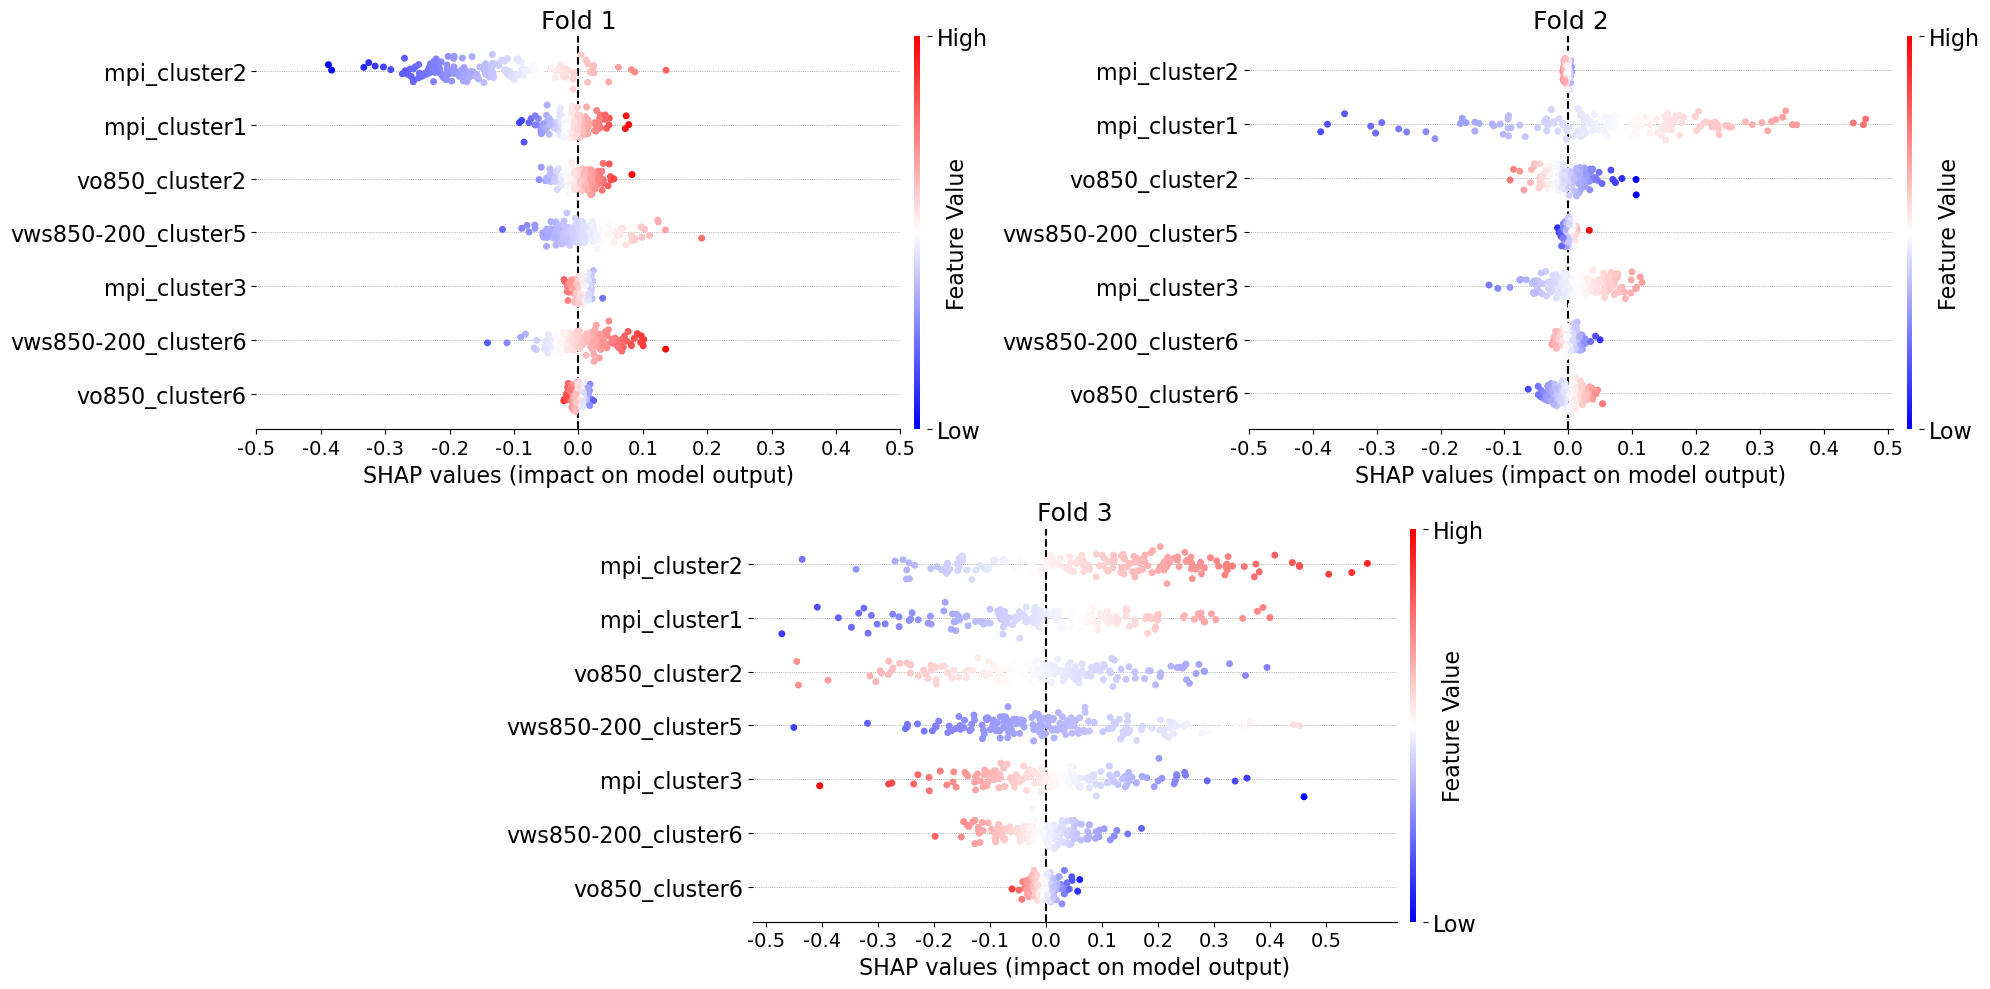

In [187]:
basin_ordered_features = ordered_features[basin]
x_axis = x_axis_arrays[basin]
fig_size = figures_size[basin][0]
fonts_size = fontsizes[basin][0]
marker_size = marker_sizes[basin][0]
# Set the figure and the gridspec for the subplots -> horizontal layout
fig = plt.figure(figsize=fig_size)
gs = gridspec.GridSpec(2, 4, figure=fig)
ax_pos = [0, 2, 5]
jitter_strength = 0.12

# Cycle over the shap values of the 3 folds
for nf, shape_values in enumerate(shap_values_mlp):
    feat_names = np.array(shape_values.feature_names)
    # Set the colorbar for the subplots
    data_values = shape_values.data
    vmin = data_values.min()
    vmax = data_values.max()
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    cmap = plt.get_cmap('bwr')
    # Create the subplot
    ax = fig.add_subplot(gs[ax_pos[nf]:ax_pos[nf]+2])
    # Plot the SHAP values
    for n_feat, feature in enumerate(basin_ordered_features):
        # Get the position of the feature in the SHAP values
        feat_pos = np.where(feature == feat_names)[0][0]
        # Get the data for the scatter plot
        x_data = shape_values.values[:, feat_pos]
        spread = np.random.normal(0, jitter_strength, size=x_data.shape)
        y_data = np.zeros_like(x_data) + n_feat + spread
        color_data = data_values[:, feat_pos]
        # Plot the scatter plot
        ax.scatter(x_data, y_data, c=color_data, cmap=cmap, norm=norm, s=marker_size)
    # Add a colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, fraction=0.05, pad=0.01)
    cbar.ax.set_aspect(50) # adjust the aspect ratio to thin colorbar
    cbar.set_ticks([vmin, vmax]) # set the ticks
    cbar.set_ticklabels(['Low', 'High'], fontsize=fonts_size[1]) # set the tick labels
    cbar.outline.set_visible(False) # remove the colorbar outline
    cbar.set_label('Feature Value', labelpad=-30, fontsize=fonts_size[1])
    # Set yticks
    ax.set_yticks(np.arange(len(basin_ordered_features)))
    ax.set_yticklabels(basin_ordered_features, fontdict={'fontsize': fonts_size[1]})
    # Set xticks
    ax.set_xticks(x_axis)
    ax.set_xticklabels(x_axis, fontdict={'fontsize': fonts_size[0]})
    ax.set_xlabel('SHAP values (impact on model output)', fontdict={'fontsize': fonts_size[1]})
    # Add a vertical line at 0
    ax.axvline(x=0, color='black', linestyle='--', zorder=0)
    # Add horizontal lines at each feature
    for n_feat in range(len(basin_ordered_features)):
        ax.axhline(y=n_feat, color='grey', linestyle=':', linewidth=0.5, zorder=0)
    # Set the title
    ax.set_title(f'Fold {nf+1}', fontsize=fonts_size[2])
    # Remove axis outline
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
# Adjust the layout
fig.set_tight_layout(True)
# Save the figure
file_path = os.path.join('figures', f'{basin}', f'shap_analysis_{basin}.pdf')
fig.savefig(file_path, format='pdf', bbox_inches='tight', dpi=300)
plt.show()

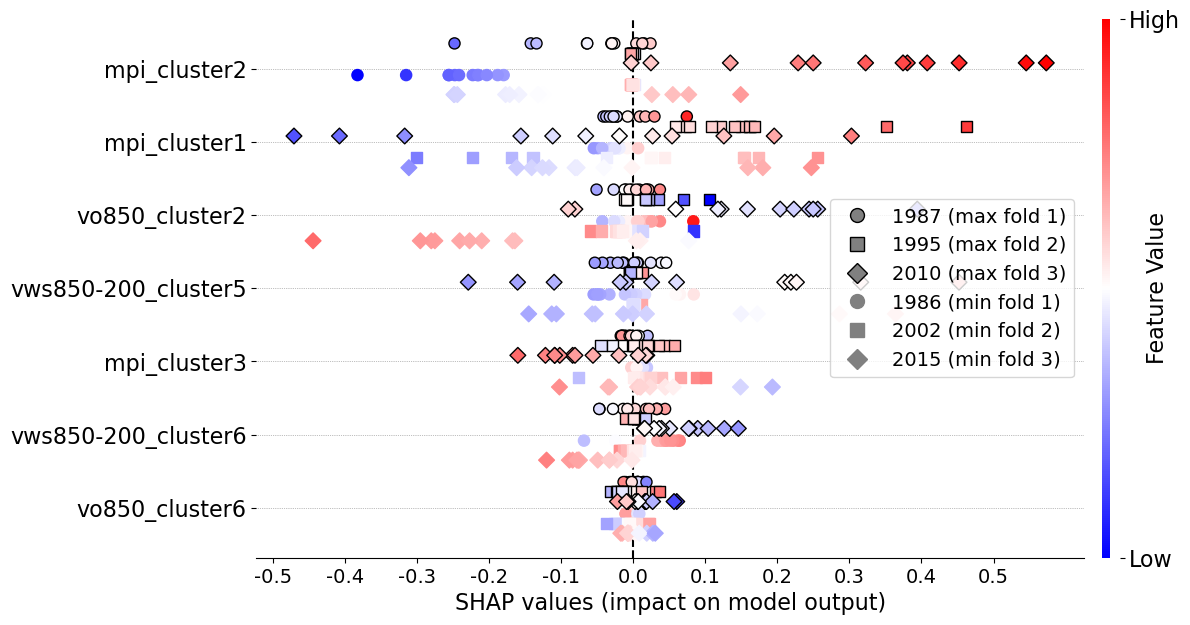

In [188]:
basin_years_couple = years_couples[basin]
fig_size = figures_size[basin][1]
fonts_size = fontsizes[basin][1]
marker_size = marker_sizes[basin][1]
# Set the figure and the gridspec for the subplots -> vertical layout
fig = plt.figure(figsize=fig_size)
gs = gridspec.GridSpec(3, 1, figure=fig)
ax = fig.add_subplot(gs[0])
vmins = []
vmaxs = []
for yb, years_for_analysis in enumerate(basin_years_couple):
    # Indentify the fold of the years considered
    fold = test_years_df.loc[years_for_analysis[0], 'fold']
    shap_values_fold = shap_values_mlp[fold]
    Y_test_fold = Y_test[fold]
    # Set the colorbar for this subplot
    shap_years = []
    for yy, year in enumerate(years_for_analysis):
        indices = Y_test_fold.index.year == year
        shap_year = shap_values_fold[indices]
        shap_years.append(shap_year)
    data_values = np.array([shap_year.data for shap_year in shap_years])
    vmin = data_values.min()
    vmax = data_values.max()
    vmins.append(vmin)
    vmaxs.append(vmax)
vmin = min(vmins)
vmax = max(vmaxs)
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.get_cmap('bwr')
# List for legend handles
legend_handles = []
# Set the different markers 
markers = ['o', 's', 'D']
for yb, years_for_analysis in enumerate(basin_years_couple):
    # Indentify the fold of the years considered
    fold = test_years_df.loc[years_for_analysis[0], 'fold']
    shap_values_fold = shap_values_mlp[fold]
    Y_test_fold = Y_test[fold]
    # Loop over the two years to plot the SHAP values
    for yy, year in enumerate(years_for_analysis):
        indices = Y_test_fold.index.year == year
        shap_year = shap_values_fold[indices]
        # Get the feature names and the data values
        feat_names = np.array(shap_year.feature_names)
        data_values = shap_year.data
        # Set a positions, markers and labels for the scatter plot
        yb_pos = 0.40*(2-yb) if yy == 0 else -0.40*yb
        yy_pos = 0.25 if yy == 0 else -0.25
        year_kind = 'max' if yy == 0 else 'min'
        # Make the scatter plot cycling over the predefined ordered features
        shape = markers[yb]
        for n_feat, feature in enumerate(basin_ordered_features):
            # Get the position of the feature in the SHAP values
            feat_pos = np.where(feature == feat_names)[0][0]
            # Get the data for the scatter plot
            x_data = shap_year.values[:, feat_pos]
            y_data = np.zeros_like(x_data) + n_feat*3 + yy_pos + yb_pos
            color_data = data_values[:, feat_pos]
            # Plot the scatter plot
            if yy == 0:
                ax.scatter(x_data, y_data, c=color_data, marker=shape, cmap=cmap, norm=norm, edgecolors='k', s=marker_size[0])
            else:
                ax.scatter(x_data, y_data, c=color_data, marker=shape, cmap=cmap, norm=norm, s=marker_size[0])
        # Add a legend handle for the year
        if yy == 0:
            legend_handle = mlines.Line2D([], [], color='grey', marker=shape, linestyle='None', 
                                          markeredgecolor='k', markersize=marker_size[1], label=f'{year} ({year_kind} fold {fold+1})')
        else:
            legend_handle = mlines.Line2D([], [], color='grey', marker=shape, linestyle='None', 
                                          markersize=marker_size[1], label=f'{year} ({year_kind} fold {fold+1})')
        legend_handles.append(legend_handle)
# Add legend - reorganized
legend_handles = np.asarray(legend_handles)
new_legend_handles = legend_handles.copy()
new_legend_handles[3] = legend_handles[1]
new_legend_handles[1] = legend_handles[2]
new_legend_handles[4] = legend_handles[3]
new_legend_handles[2] = legend_handles[4]
ax.legend(handles=new_legend_handles.tolist(), loc='center right', fontsize=fonts_size[2])
# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, fraction=0.04, pad=0.01)
cbar.ax.set_aspect(50) # adjust the aspect ratio to thin colorbar
cbar.set_ticks([vmin, vmax]) # set the ticks
cbar.set_ticklabels(['Low', 'High'], fontsize=fonts_size[1]) # set the tick labels
cbar.outline.set_visible(False) # remove the colorbar outline
cbar.set_label('Feature Value', fontsize=fonts_size[1], labelpad=-25)
# Set yticks
ax.set_yticks(np.arange(len(basin_ordered_features)*3)[::3])
ax.set_yticklabels(basin_ordered_features, fontdict={'fontsize': fonts_size[1]})
# Set xticks
ax.set_xticks(x_axis)
ax.set_xticklabels(x_axis, fontdict={'fontsize': fonts_size[0]})
ax.set_xlabel('SHAP values (impact on model output)', fontsize=fonts_size[1])
# Add a vertical line at 0
ax.axvline(x=0, color='black', linestyle='--', zorder=0)
# Add horizontal lines at each feature
for n_feat in np.arange(len(basin_ordered_features)*3)[::3]:
    ax.axhline(y=n_feat, color='grey', linestyle=':', linewidth=0.5, zorder=0)
# Remove axis outline
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
# Adjust the layout
fig.set_tight_layout(True)
# Save figure
file_path = os.path.join('figures', f'{basin}', f'shap_analysis_{basin}_years_maxmin.pdf')
fig.savefig(file_path, format='pdf', bbox_inches='tight', dpi=300)
plt.show()

In [170]:
## Set different parameters for following plots ##
# # Dictionary containing most important features for each basin and corresponding units
# important_features = {
#     'GLB': ['sst_cluster9', 'abs_vo850_cluster5', 'mpi_cluster12']
# }
# metrics_units = {
#     'GLB': ['°C', 's$^{-1}$', 'ms$^{-1}$']
# }

# features_imp = important_features[basin]
# units = metrics_units[basin]

# markers = ['o', 's', 'D']
# # Create the figure and axis
# fig = plt.figure(figsize=(24, 6))
# gs = gridspec.GridSpec(1, 3, figure=fig)
# for ff, feature in enumerate(features_imp):
#     ax1 = fig.add_subplot(gs[ff])
#     for yy, y_cpl in enumerate(basin_years_couple):
#         feature_ts_year1 = predictors_df.loc[predictors_df.index.year == basin_years_couple[yy][0], feature]
#         ax1.plot(feature_ts_year1.index.month, feature_ts_year1.values, 'r', label=f'{basin_years_couple[yy][0]} (max)',
#                  marker=markers[yy], linewidth=2, markersize=8)
#     for yy, y_cpl in enumerate(basin_years_couple):
#         feature_ts_year2 = predictors_df.loc[predictors_df.index.year == basin_years_couple[yy][1], feature]
#         ax1.plot(feature_ts_year2.index.month, feature_ts_year2.values, 'b', label=f'{basin_years_couple[yy][1]} (min)', 
#                  marker=markers[yy], linewidth=2, markersize=8)
#     # ax1.set_xlabel('Month', fontdict={'fontsize': 16})
#     ax1.set_ylabel(f'{units[ff]}', fontdict={'fontsize': 16})
#     ax1.set_xticks(np.arange(2, 13, 2))
#     ax1.set_xticklabels(['Feb', 'Apr', 'Jun', 'Aug', 'Oct', 'Dec'], fontdict={'fontsize': 14})
#     ax1.set_yticks(ax1.get_yticks())
#     ax1.set_yticklabels(ax1.get_yticks(), fontdict={'fontsize': 14})
#     ax1.set_title(feature, fontsize=16)
#     # Set x-axis format properly
#     ax1.set_xlim([0.5, 12.5])
#     # Show legend
#     if ff == 1:
#         ax1.legend(loc=[-0.78, -0.2], ncol=6, fontsize=16)
#         a = ax1.get_yticks()
#         ax1.set_yticklabels(np.round(ax1.get_yticks(), 5), fontdict={'fontsize': 14})
# # fig.set_tight_layout(True)
# # Show the plot
# plt.show()